# Binary Classification

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [74]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing   import StandardScaler
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import roc_curve, roc_auc_score

from utils import custom_predictions, precision_recall_scores, plot_decision_boundary, save_figure

OPTIMIZE = True
LABELS = ["cHL", "PMBCL"]

## Data loading and preparation

In [2]:
data_dir  = "./data"
data_file = "db_mediastinalbulky_reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    119 non-null    float64
 1   lymphoma_type                         119 non-null    float64
 2   CONVENTIONAL_SUVbwmidpoint            119 non-null    float64
 3   CONVENTIONAL_SUVbwmean                119 non-null    float64
 4   CONVENTIONAL_TLG(mL)[onlyForPETorNM]  119 non-null    float64
 5   CONVENTIONAL_SUVbwSkewness            119 non-null    float64
 6   CONVENTIONAL_SUVbwKurtosis            119 non-null    float64
 7   GLCM_Homogeneity[=InverseDifference]  119 non-null    float64
 8   GLCM_Entropy_log10                    119 non-null    float64
 9   GLRLM_SRE                             119 non-null    float64
 10  GLRLM_LRE                             119 non-null    float64
 11  GLZLM_LGZE         

### Input/output preparation

In [11]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

X  = data.query("lymphoma_type != 2")[X_cols] . to_numpy()
y  = data.query("lymphoma_type != 2")[y_cols] . to_numpy() . flatten()
y  = ( y == 3 )   # PMBCL/cHL classification
id = data.query("lymphoma_type != 2")["ID"] . to_numpy() . flatten()

ratio = len(y[y == True]) / len(y[y == False])
print ( "PMBCL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio) )

PMBCL-cHL ratio on data-set : 35.8%


### Train-set and test-set splitting

In [21]:
sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train , id_train = X[idx_train] , y[idx_train] , id[idx_train]
  X_test  , y_test  , id_test  = X[idx_test]  , y[idx_test]  , id[idx_test]

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "PMBCL-cHL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "PMBCL-cHL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

PMBCL-cHL ratio on train-set : 35.4%
PMBCL-cHL ratio on test-set  : 37.5%


In [22]:
print ( f"First 5 IDs on train-set : {id_train[:5].astype(np.int32)}" )
print ( f"First 5 IDs on test-set  : {id_test[:5].astype(np.int32)}" )

First 5 IDs on train-set : [28 48 50 30 67]
First 5 IDs on test-set  : [63 84 73 69 79]


### Data preprocessing

In [28]:
scaler = StandardScaler()

X_train_original = X_train

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

print ( f"Resulting mean on train-set : {np.mean(X_train, axis = 0)}" )
print ( f"Resulting mean on test-set  : {np.mean(X_test, axis = 0)}" )

Resulting mean on train-set : [ 8.83131951e-18  1.00929366e-17  2.46015329e-17  2.71247671e-17
  1.00929366e-17 -5.04646829e-18 -2.52323415e-18  2.52323415e-18
  2.52323415e-18 -8.83131951e-18 -1.26161707e-17]
Resulting mean on test-set  : [-0.08842036 -0.0349631  -0.25173779 -0.09722866 -0.11569242 -0.05333558
 -0.01382648  0.06284176 -0.0991686   0.02968295 -0.06174364]


## Dummy classifier

In [57]:
clf_dummy = DummyClassifier (strategy = "stratified")

dummy_scores = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3, method = "predict_proba" )
y_train_pred = ( dummy_scores[:,1] == 1)

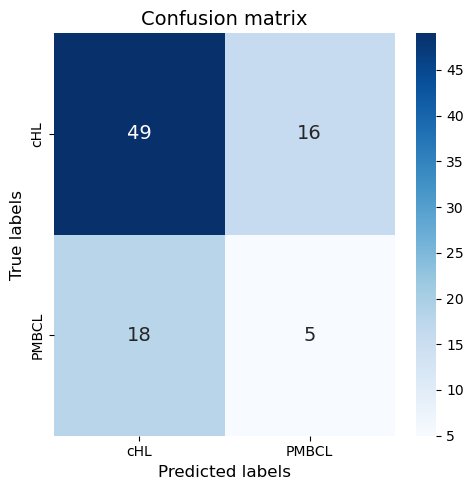

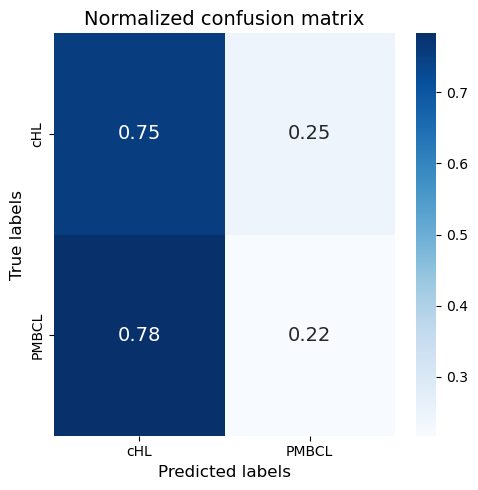

In [59]:
_ = precision_recall_scores ( y_train, y_train_pred, labels = LABELS, show_conf_matrix = True, fig_name = "dummy-clf" )

## Logistic regression

In [32]:
clf_logreg = LogisticRegression ( 
                                  penalty = "l2" ,
                                  class_weight = "balanced" ,
                                  solver = "liblinear" ,
                                  max_iter = 500 ,
                                  multi_class = "ovr" ,
                                )

logreg_scores = cross_val_predict ( clf_logreg, X_train, y_train, cv = 3, method = "predict_proba" )

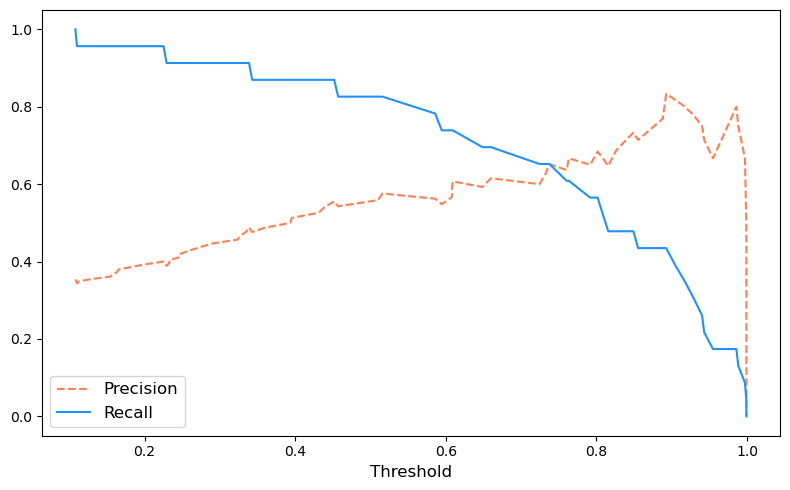

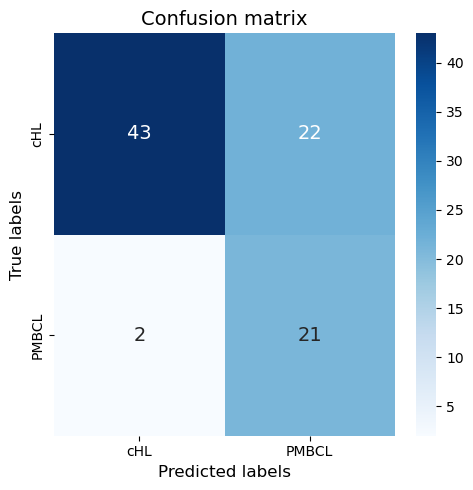

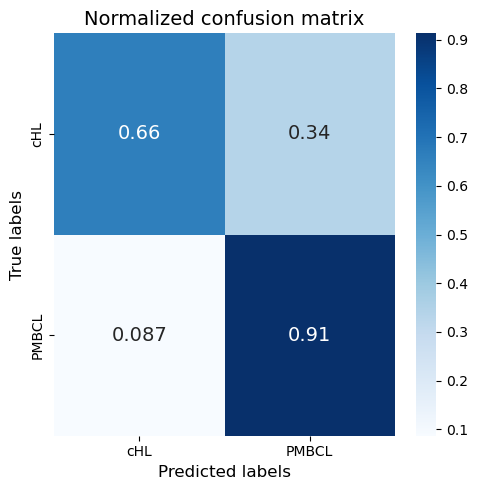

In [60]:
y_train_pred_90, _ = custom_predictions ( y_train, logreg_scores, recall_score = 0.9, show_curves = True, fig_name = "log-reg_prec-rec-curves" )
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = LABELS, show_conf_matrix = True, fig_name = "log-reg_rec90" )

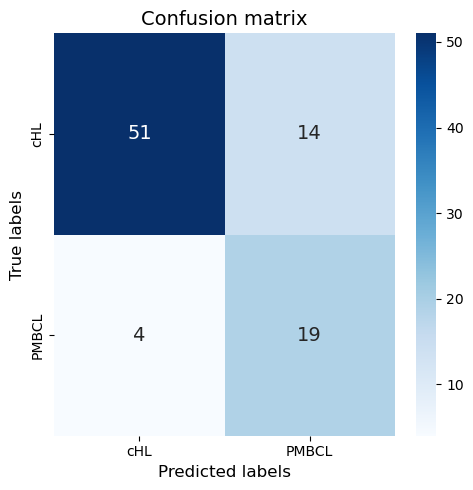

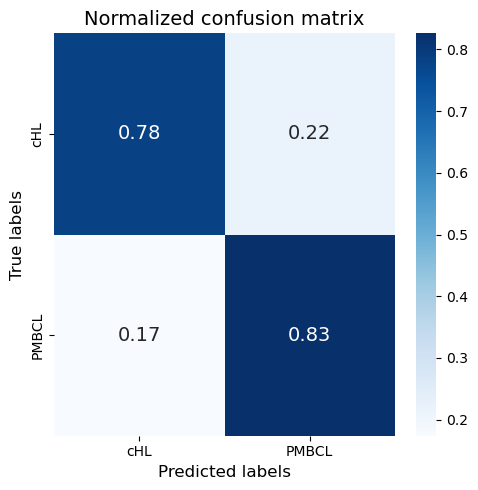

In [61]:
y_train_pred_80, _ = custom_predictions ( y_train, logreg_scores, recall_score = 0.8 )
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = LABELS, show_conf_matrix = True, fig_name = "log-reg_rec80" )

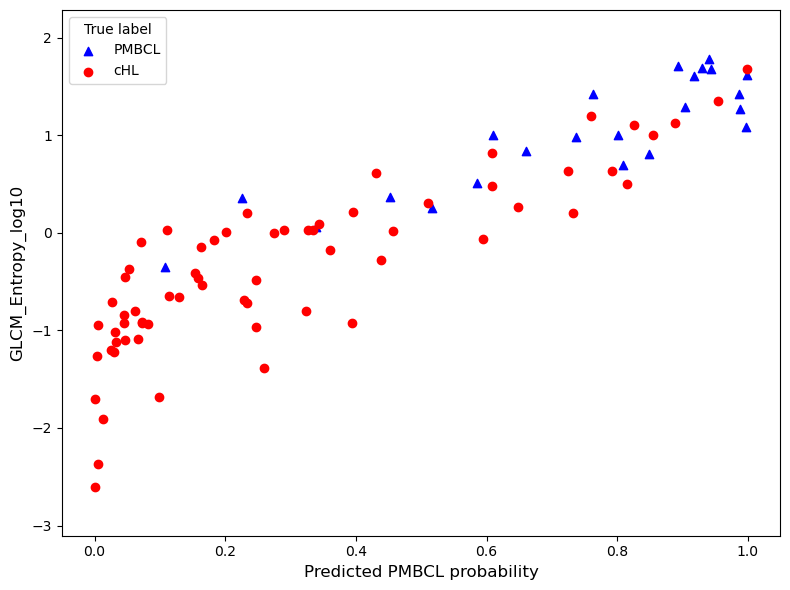

In [41]:
plot_decision_boundary ( clf_logreg, X_train, y_train, labels = LABELS, feature_names = X_cols, 
                         strategy = None, fig_name = "log-reg_scatter-plot" )

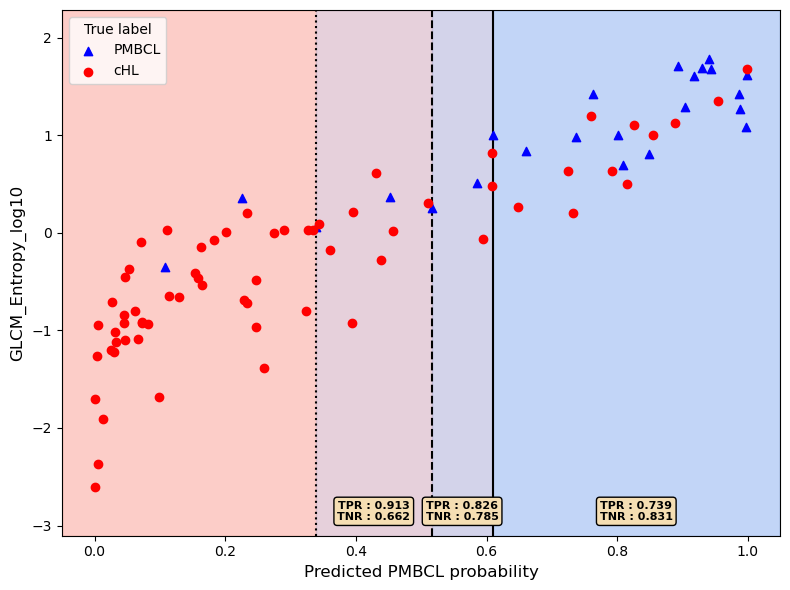

In [43]:
plot_decision_boundary ( clf_logreg, X_train, y_train, labels = LABELS, feature_names = X_cols, 
                         strategy = "recall", fig_name = "log-reg_boundaries" )

## Linear SVM

In [65]:
clf_linsvm = SVC ( kernel = "linear", probability = True )

linsvm_scores = cross_val_predict ( clf_linsvm, X_train, y_train, cv = 3, method = "predict_proba" )

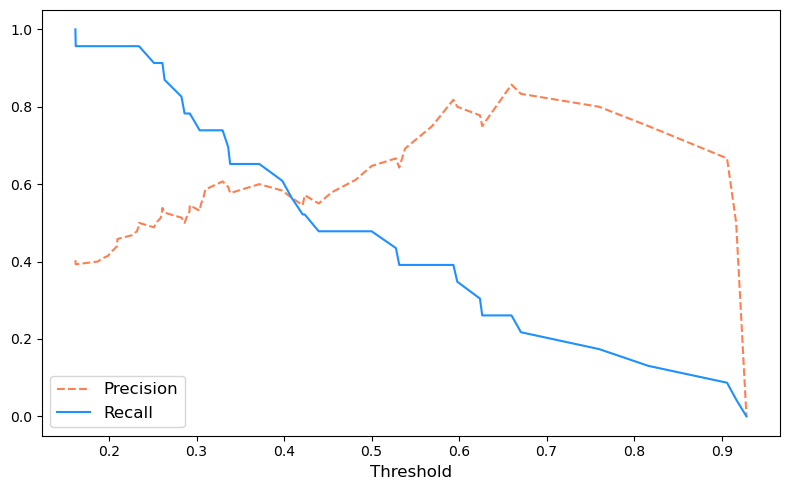

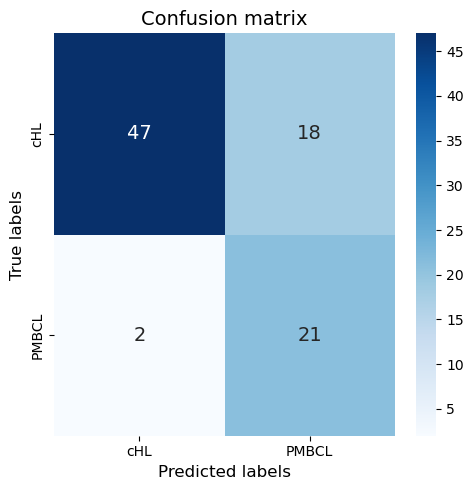

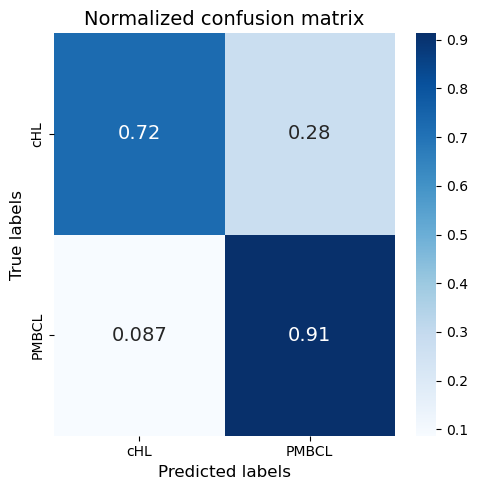

In [66]:
y_train_pred_90, _ = custom_predictions ( y_train, linsvm_scores, recall_score = 0.90, show_curves = True, fig_name = "lin-svm_prec-rec-curves" )
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = LABELS, show_conf_matrix = True, fig_name = "lin-svm_rec90" )

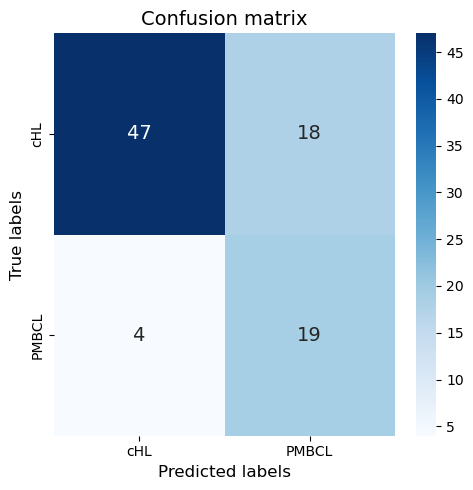

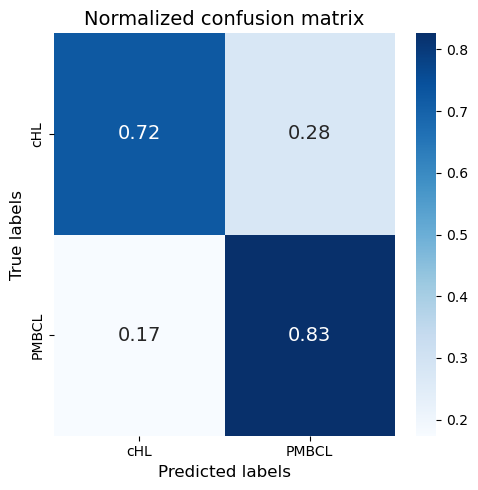

In [67]:
y_train_pred_80, _ = custom_predictions ( y_train, linsvm_scores, recall_score = 0.80 )
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = LABELS, show_conf_matrix = True, fig_name = "lin-svm_rec80" )

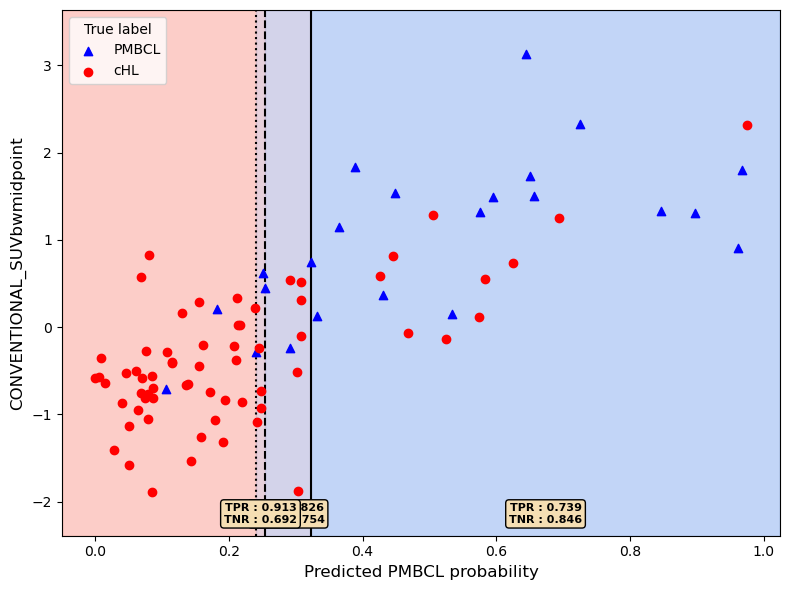

In [68]:
plot_decision_boundary ( clf_linsvm, X_train, y_train, labels = LABELS, feature_names = X_cols, 
                         strategy = "recall", fig_name = "lin-svm_boundaries" )

## Random forest

In [46]:
clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      # criterion = "gini" ,
                                      # max_features = "sqrt" ,
                                      # max_leaf_nodes = 10 ,
                                      max_depth = 1 ,
                                      # class_weight = "balanced" ,
                                    )

forest_scores = cross_val_predict ( clf_forest, X_train, y_train, cv = 3, method = "predict_proba" )

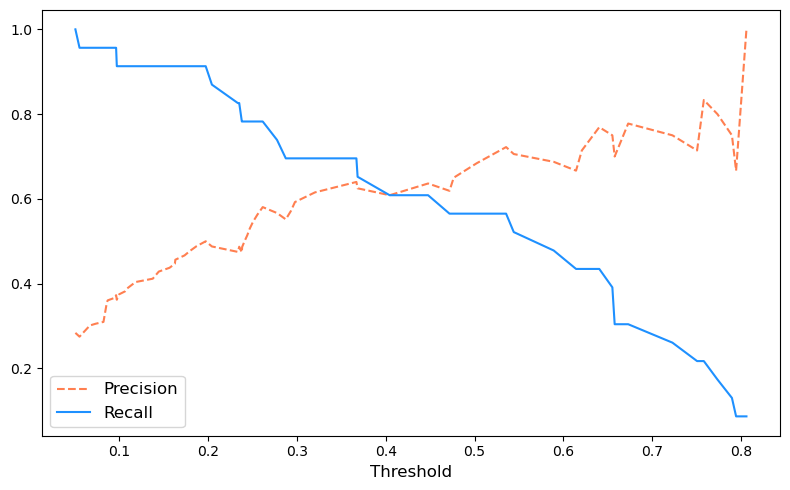

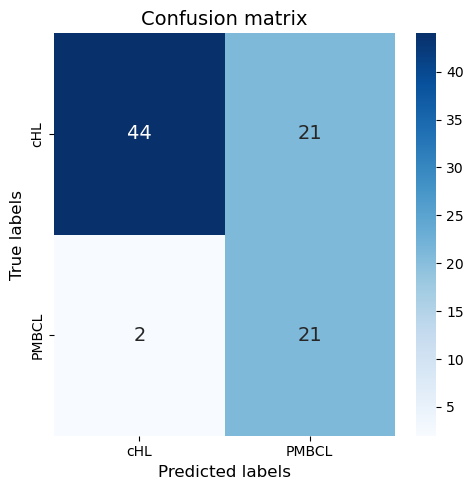

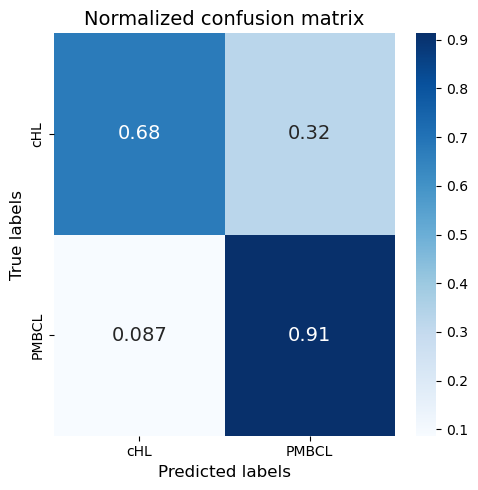

In [62]:
y_train_pred_90, _ = custom_predictions ( y_train, forest_scores, recall_score = 0.90, show_curves = True, fig_name = "rnd-frs_prec-rec-curves" )
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = LABELS, show_conf_matrix = True, fig_name = "rnd-frs_rec90" )

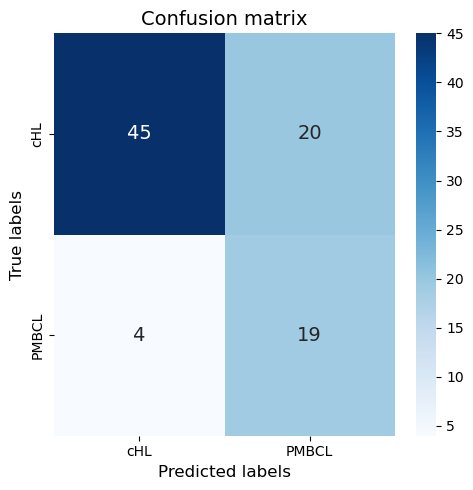

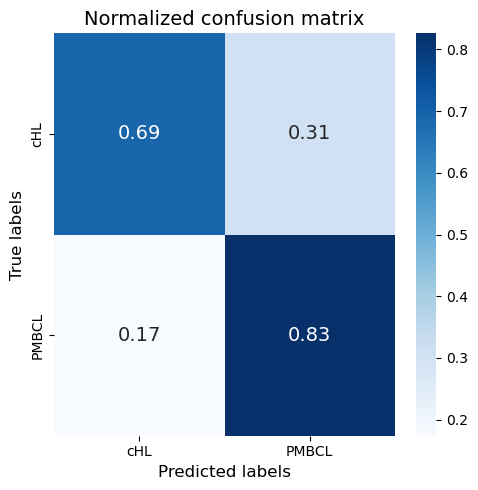

In [48]:
y_train_pred_80, _ = custom_predictions ( y_train, forest_scores, recall_score = 0.80 )
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = LABELS, show_conf_matrix = True, fig_name = "rnd-frs_rec80" )

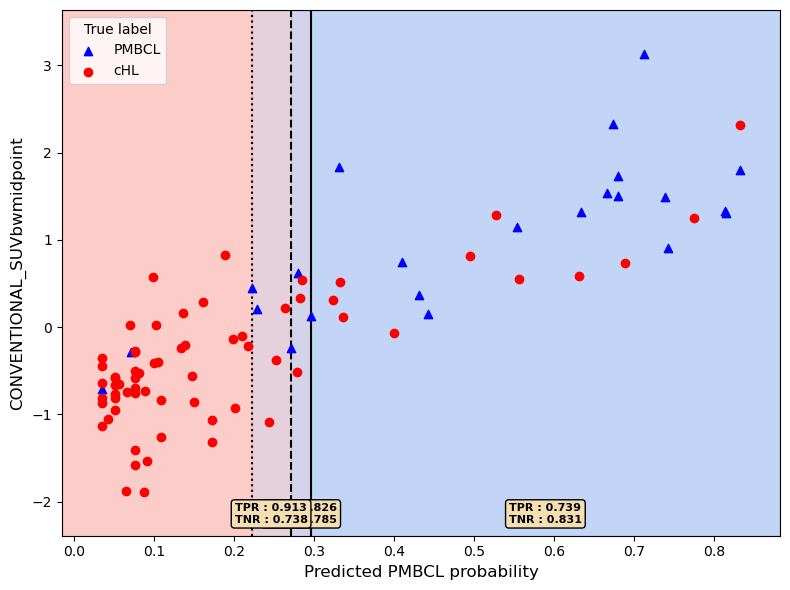

In [49]:
plot_decision_boundary ( clf_forest, X_train, y_train, labels = LABELS, feature_names = X_cols, 
                         strategy = "recall", fig_name = "rnd-frs_boundaries" )

## Gradient BDT

In [53]:
clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.2 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        # max_features  = None , 
                                        # max_leaf_nodes = 10 ,
                                        max_depth = 1       ,
                                      )

gbdt_scores = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3, method = "predict_proba" )

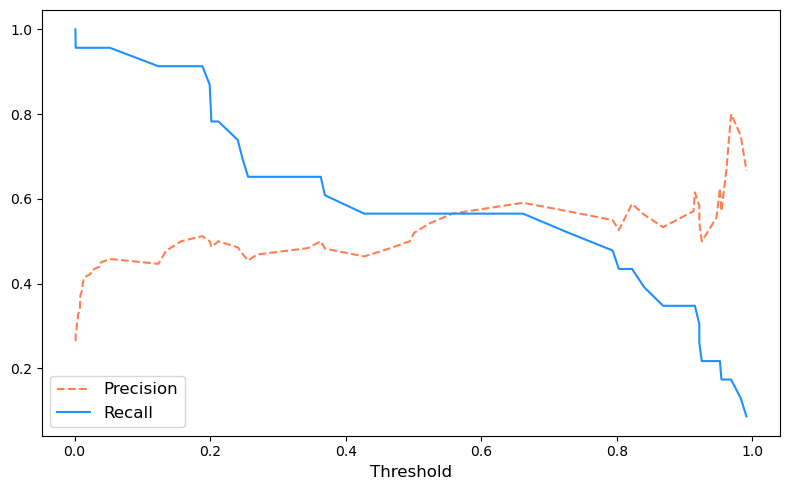

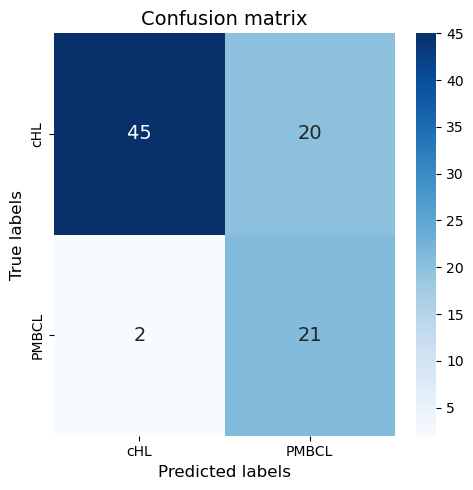

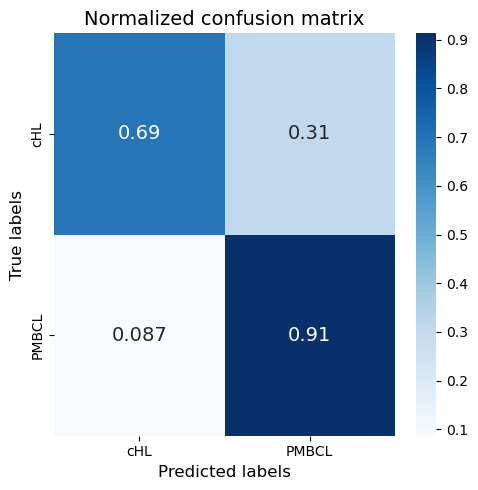

In [52]:
y_train_pred_90, _ = custom_predictions ( y_train, gbdt_scores, recall_score = 0.90, show_curves = True, fig_name = "rnd-frs_prec-rec-curves" )
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = LABELS, show_conf_matrix = True, fig_name = "rnd-frs_rec90" )

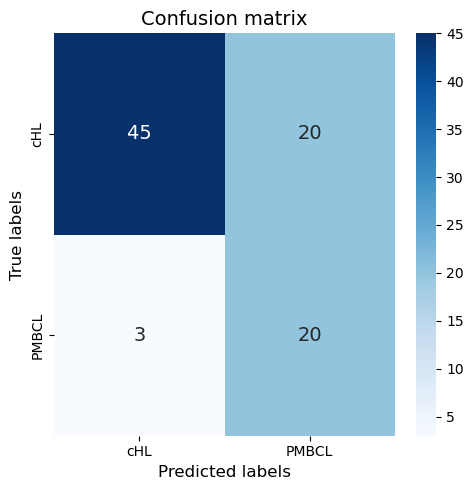

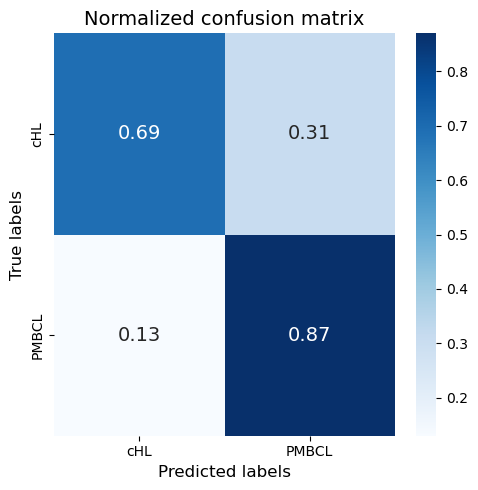

In [54]:
y_train_pred_80, _ = custom_predictions ( y_train, gbdt_scores, recall_score = 0.80 )
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = LABELS, show_conf_matrix = True, fig_name = "rnd-frs_rec80" )

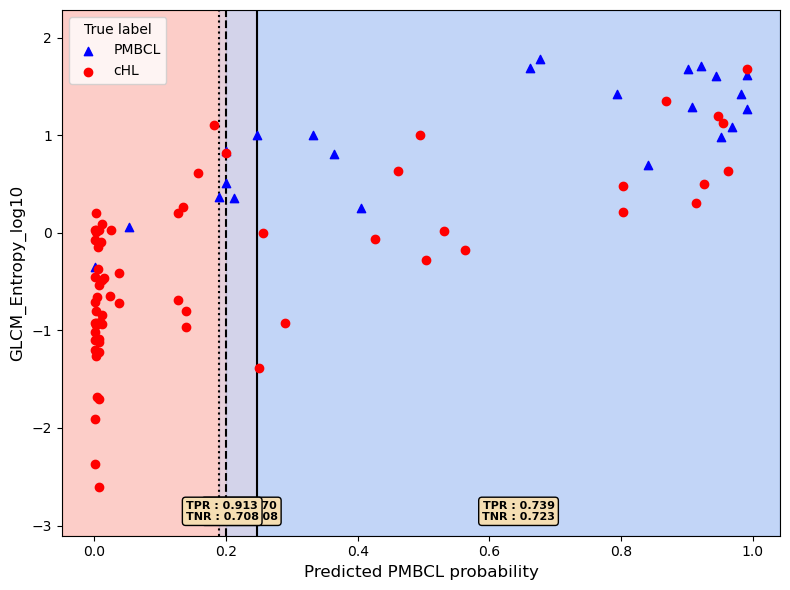

In [55]:
plot_decision_boundary ( clf_gbdt, X_train, y_train, labels = LABELS, feature_names = X_cols, 
                         strategy = "recall", fig_name = "gbdt_boundaries" )

## Models comparison

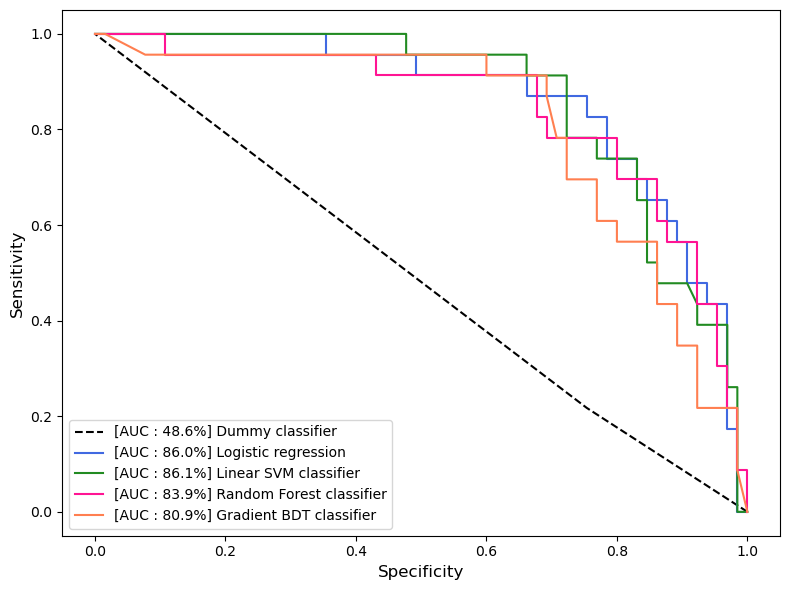

In [78]:
auc_scores = list()

model_scores = [dummy_scores[:,1], logreg_scores[:,1], linsvm_scores[:,1], forest_scores[:,1], gbdt_scores[:,1]]
colors = ["black", "royalblue", "forestgreen", "deeppink", "coral"]
styles = ["--", "-", "-", "-", "-"]
labels = ["Dummy classifier", "Logistic regression", "Linear SVM classifier", "Random Forest classifier", "Gradient BDT classifier"]

plt.figure (figsize = (8,6), dpi = 100)
plt.xlabel ("Specificity", fontsize = 12)
plt.ylabel ("Sensitivity", fontsize = 12)
for score, col, stl, lbl in zip (model_scores, colors, styles, labels):
  auc = roc_auc_score ( y_train, score )
  auc_scores . append ( auc )
  fpr, tpr, _ = roc_curve ( y_train, score )
  plt.plot (1 - fpr, tpr, color = col, linestyle = stl, label = f"[AUC : {100*auc:.1f}%] {lbl}")
plt.legend (loc = "lower left", fontsize = 10)
save_figure ("roc-auc-curves")
plt.show()